## 🔧 Instalación de Dependencias

In [1]:
# Instalación de dependencias necesarias
!pip install torch numpy pandas scikit-learn tqdm matplotlib seaborn kagglehub psutil

# Imports principales
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import psutil
import kagglehub
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("✅ Dependencias instaladas y configuradas correctamente")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## 📊 Carga del Dataset

🎯 CARGANDO DATOS CON PARÁMETROS:
   min_seq_len=3, max_seq_len=50, min_item_freq=5
🔄 Descargando dataset RetailRocket...


100%|██████████| 291M/291M [00:02<00:00, 120MB/s] 

Extracting files...


📖 Cargando datos...
📊 Estadísticas iniciales:
   Total interacciones: 2,664,312
   Usuarios únicos: 1,404,179
   Items únicos: 234,838
🔧 Creando secuencias de usuario...
📏 Después de filtrar por longitud [3, 50]:
   Secuencias restantes: 189,924
🎯 Filtrando items poco frecuentes...
   Items frecuentes (>=5 apariciones): 44,022
📋 Estadísticas finales:
   Secuencias válidas: 153,745
   Items únicos: 44,022
   Longitud promedio: 5.65
   Longitud mediana: 4


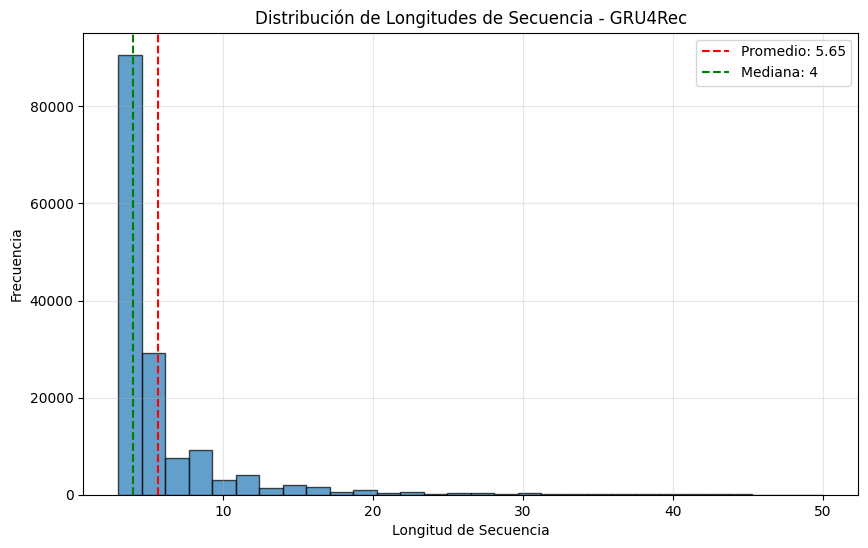

✅ Dataset cargado exitosamente:
   153,745 secuencias
   44,022 items únicos
   Vocabulario size: 44023


In [2]:
def load_and_preprocess_retailrocket(min_seq_len=3, max_seq_len=50, min_item_freq=5):
    """
    Carga y preprocesa el dataset RetailRocket
    """
    print("🔄 Descargando dataset RetailRocket...")

    # Descargar dataset
    path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")
    events_path = os.path.join(path, 'events.csv')

    # Leer y filtrar datos
    print("📖 Cargando datos...")
    df = pd.read_csv(events_path)
    df = df[df['event'] == 'view']  # Solo eventos de visualización
    df = df.sort_values(by=['visitorid', 'timestamp'])

    print(f"📊 Estadísticas iniciales:")
    print(f"   Total interacciones: {len(df):,}")
    print(f"   Usuarios únicos: {df['visitorid'].nunique():,}")
    print(f"   Items únicos: {df['itemid'].nunique():,}")

    # Crear secuencias por usuario
    print("🔧 Creando secuencias de usuario...")
    user_sequences = df.groupby('visitorid')['itemid'].apply(list).reset_index()
    user_sequences.columns = ['user_id', 'item_sequence']

    # Filtrar por longitud de secuencia
    user_sequences['seq_len'] = user_sequences['item_sequence'].apply(len)
    filtered_sequences = user_sequences[
        (user_sequences['seq_len'] >= min_seq_len) &
        (user_sequences['seq_len'] <= max_seq_len)
    ]

    print(f"📏 Después de filtrar por longitud [{min_seq_len}, {max_seq_len}]:")
    print(f"   Secuencias restantes: {len(filtered_sequences):,}")

    # Filtrar items poco frecuentes para reducir vocabulario
    print("🎯 Filtrando items poco frecuentes...")
    all_items = []
    for seq in filtered_sequences['item_sequence']:
        all_items.extend(seq)

    item_counts = Counter(all_items)
    frequent_items = {item for item, count in item_counts.items() if count >= min_item_freq}

    print(f"   Items frecuentes (>={min_item_freq} apariciones): {len(frequent_items):,}")

    # Filtrar secuencias para mantener solo items frecuentes
    def filter_sequence(seq):
        return [item for item in seq if item in frequent_items]

    filtered_sequences['item_sequence'] = filtered_sequences['item_sequence'].apply(filter_sequence)

    # Remover secuencias que quedaron muy cortas después del filtrado
    filtered_sequences['seq_len'] = filtered_sequences['item_sequence'].apply(len)
    final_sequences = filtered_sequences[filtered_sequences['seq_len'] >= min_seq_len]

    print(f"📋 Estadísticas finales:")
    print(f"   Secuencias válidas: {len(final_sequences):,}")
    print(f"   Items únicos: {len(frequent_items):,}")
    print(f"   Longitud promedio: {final_sequences['seq_len'].mean():.2f}")
    print(f"   Longitud mediana: {final_sequences['seq_len'].median():.0f}")

    # Crear mapeo de items a índices (0 reservado para padding)
    item_to_idx = {item: idx + 1 for idx, item in enumerate(sorted(frequent_items))}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}

    # Convertir secuencias a índices
    sequences_idx = []
    for seq in final_sequences['item_sequence']:
        seq_idx = [item_to_idx[item] for item in seq]
        sequences_idx.append(seq_idx)

    # Estadísticas de distribución
    seq_lengths = [len(seq) for seq in sequences_idx]
    plt.figure(figsize=(10, 6))
    plt.hist(seq_lengths, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(seq_lengths), color='red', linestyle='--',
                label=f'Promedio: {np.mean(seq_lengths):.2f}')
    plt.axvline(np.median(seq_lengths), color='green', linestyle='--',
                label=f'Mediana: {np.median(seq_lengths):.0f}')
    plt.xlabel('Longitud de Secuencia')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Longitudes de Secuencia - GRU4Rec')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return sequences_idx, item_to_idx, idx_to_item

# Cargar y preprocesar datos
print("🎯 CARGANDO DATOS CON PARÁMETROS:")
print("   min_seq_len=3, max_seq_len=50, min_item_freq=5")

sequences, item_to_idx, idx_to_item = load_and_preprocess_retailrocket(
    min_seq_len=3,
    max_seq_len=50,
    min_item_freq=5
)

print(f"✅ Dataset cargado exitosamente:")
print(f"   {len(sequences):,} secuencias")
print(f"   {len(item_to_idx):,} items únicos")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding


## 🔄 División del Dataset

In [3]:
# CLASE DATASET
class SequentialDataset(Dataset):
    """Dataset optimizado para secuencias con padding dinámico"""

    def __init__(self, sequences, max_len=50):
        self.sequences = sequences
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # Crear input y target sequences
        if len(seq) <= self.max_len:
            # Secuencia completa
            input_seq = seq[:-1]  # Todos menos el último
            target_seq = seq[1:]  # Todos menos el primero
        else:
            # Truncar secuencia
            input_seq = seq[:self.max_len]
            target_seq = seq[1:self.max_len+1]

        # Padding
        input_padded = [0] * (self.max_len - len(input_seq)) + input_seq
        target_padded = [0] * (self.max_len - len(target_seq)) + target_seq

        return torch.tensor(input_padded, dtype=torch.long), torch.tensor(target_padded, dtype=torch.long)

# DIVISIÓN (misma semilla random_state=42)
print("🎯 DIVIDIENDO DATASET CON SEMILLA (random_state=42)")
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

print(f"📊 División del dataset:")
print(f"   Entrenamiento: {len(train_sequences):,} secuencias")
print(f"   Prueba: {len(test_sequences):,} secuencias")

# CÁLCULO IDÉNTICO DE MAX_LEN
all_lengths = [len(seq) for seq in sequences]
max_len_95 = int(np.percentile(all_lengths, 95))
max_len_99 = int(np.percentile(all_lengths, 99))

print(f"📏 Análisis de longitudes:")
print(f"   Máximo: {max(all_lengths)}")
print(f"   Percentil 95: {max_len_95}")
print(f"   Percentil 99: {max_len_99}")

# USAR MISMO MAX_LEN
MAX_LEN = max_len_95
print(f"   Usando max_len = {MAX_LEN}")

# CREAR DATASETS IDÉNTICOS
train_dataset = SequentialDataset(train_sequences, max_len=MAX_LEN)
test_dataset = SequentialDataset(test_sequences, max_len=MAX_LEN)

# CREAR DATALOADERS CON MISMO BATCH_SIZE
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoaders creados:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Batches de entrenamiento: {len(train_loader)}")
print(f"   Batches de prueba: {len(test_loader)}")
print(f"   Max length: {MAX_LEN}")

# VERIFICAR QUE LOS DATOS SON IDÉNTICOS
sample_input, sample_target = next(iter(train_loader))
print(f"\n📝 Ejemplo de batch:")
print(f"   Input shape: {sample_input.shape}")
print(f"   Target shape: {sample_target.shape}")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding

print(f"\n🔍 VERIFICACIÓN DE IDENTIDAD:")
print(f"   ✅ Mismos filtros de preprocesamiento")
print(f"   ✅ Misma división train/test (random_state=42)")
print(f"   ✅ Mismo max_len ({MAX_LEN})")
print(f"   ✅ Mismo batch_size ({BATCH_SIZE})")
print(f"   ✅ Mismo vocabulario ({len(item_to_idx) + 1} items)")
print(f"   ✅ Mismas secuencias de datos")


🎯 DIVIDIENDO DATASET CON SEMILLA (random_state=42)
📊 División del dataset:
   Entrenamiento: 122,996 secuencias
   Prueba: 30,749 secuencias
📏 Análisis de longitudes:
   Máximo: 50
   Percentil 95: 14
   Percentil 99: 28
   Usando max_len = 14
✅ DataLoaders creados:
   Batch size: 32
   Batches de entrenamiento: 3844
   Batches de prueba: 961
   Max length: 14

📝 Ejemplo de batch:
   Input shape: torch.Size([32, 14])
   Target shape: torch.Size([32, 14])
   Vocabulario size: 44023

🔍 VERIFICACIÓN DE IDENTIDAD:
   ✅ Mismos filtros de preprocesamiento
   ✅ Misma división train/test (random_state=42)
   ✅ Mismo max_len (14)
   ✅ Mismo batch_size (32)
   ✅ Mismo vocabulario (44023 items)
   ✅ Mismas secuencias de datos


## 🧠 Implementación de ItemKNN

ItemKNN es un algoritmo de filtrado colaborativo basado en similitud entre items que utiliza la co-ocurrencia de items en sesiones para generar recomendaciones. Es un método no paramétrico que construye una matriz de similitud entre items y recomienda items similares a los que ya interactuó el usuario.

In [4]:
class ItemKNN:
    """
    ItemKNN: Item-to-Item Collaborative Filtering usando similitud de coseno

    Implementación optimizada de ItemKNN para recomendaciones secuenciales
    """

    def __init__(self, num_items, k=100):
        """
        Args:
            num_items: Número total de items en el vocabulario
            k: Número de neighbors más cercanos a considerar
        """
        self.num_items = num_items
        self.k = k
        self.item_similarity = {}  # Diccionario para almacenar similitudes
        self.item_cooccurrence = defaultdict(lambda: defaultdict(int))
        self.item_counts = defaultdict(int)

    def fit(self, sequences):
        """
        Construye la matriz de similitud basada en co-ocurrencia

        Args:
            sequences: Lista de secuencias de items
        """
        print(f"🔧 Construyendo matriz de similitud ItemKNN...")
        print(f"   K neighbors: {self.k}")
        print(f"   Número de secuencias: {len(sequences)}")

        # Contar co-ocurrencias
        for seq in tqdm(sequences, desc="Calculando co-ocurrencias"):
            # Contar apariciones de cada item
            for item in seq:
                if item != 0:  # Ignorar padding
                    self.item_counts[item] += 1

            # Contar co-ocurrencias entre items en la misma sesión
            unique_items = list(set(seq))
            unique_items = [item for item in unique_items if item != 0]  # Remover padding

            for i in range(len(unique_items)):
                for j in range(i + 1, len(unique_items)):
                    item1, item2 = unique_items[i], unique_items[j]
                    self.item_cooccurrence[item1][item2] += 1
                    self.item_cooccurrence[item2][item1] += 1

        # Calcular similitudes de coseno
        print("📊 Calculando similitudes de coseno...")
        for item1 in tqdm(self.item_cooccurrence.keys(), desc="Calculando similitudes"):
            similarities = []

            for item2, cooccur in self.item_cooccurrence[item1].items():
                if item1 != item2:
                    # Similitud de coseno
                    similarity = cooccur / (
                        np.sqrt(self.item_counts[item1]) * np.sqrt(self.item_counts[item2])
                    )
                    similarities.append((item2, similarity))

            # Mantener solo los k más similares
            similarities.sort(key=lambda x: x[1], reverse=True)
            self.item_similarity[item1] = similarities[:self.k]

        print(f"✅ Matriz de similitud construida!")
        print(f"   Items con similitudes: {len(self.item_similarity)}")
        print(f"   Promedio de neighbors por item: {np.mean([len(v) for v in self.item_similarity.values()]):.2f}")

    def predict(self, sequence, top_k=20):
        """
        Predice los siguientes items para una secuencia

        Args:
            sequence: Secuencia de items (sin padding)
            top_k: Número de items a recomendar

        Returns:
            Lista de items recomendados
        """
        if not sequence:
            return []

        # Obtener items únicos de la secuencia (sin padding)
        sequence_items = [item for item in sequence if item != 0]
        if not sequence_items:
            return []

        # Calcular scores para todos los items
        item_scores = defaultdict(float)

        for item in sequence_items:
            if item in self.item_similarity:
                for similar_item, similarity in self.item_similarity[item]:
                    # No recomendar items que ya están en la secuencia
                    if similar_item not in sequence_items:
                        item_scores[similar_item] += similarity

        # Ordenar por score y devolver top_k
        recommendations = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
        return [item for item, score in recommendations[:top_k]]

# Crear modelo ItemKNN
VOCAB_SIZE = len(item_to_idx) + 1  # +1 para padding
K_NEIGHBORS = 100

model = ItemKNN(
    num_items=VOCAB_SIZE,
    k=K_NEIGHBORS
)

print(f"🏗️  Arquitectura de ItemKNN:")
print(f"   Vocabulario: {VOCAB_SIZE:,} items")
print(f"   K neighbors: {K_NEIGHBORS}")
print(f"   Método: Similitud de coseno")
print(f"   Parámetros entrenables: 0 (método no paramétrico)")

# La verificación de forward pass no aplica para ItemKNN
print(f"\n✅ Modelo ItemKNN inicializado correctamente")
print(f"   Algoritmo: Collaborative Filtering basado en items")
print(f"   Tipo: No paramétrico (sin entrenamiento de pesos)")


🏗️  Arquitectura de ItemKNN:
   Vocabulario: 44,023 items
   K neighbors: 100
   Método: Similitud de coseno
   Parámetros entrenables: 0 (método no paramétrico)

✅ Modelo ItemKNN inicializado correctamente
   Algoritmo: Collaborative Filtering basado en items
   Tipo: No paramétrico (sin entrenamiento de pesos)


## 🚀 Entrenamiento de ItemKNN

In [6]:
# ENTRENAMIENTO DE ITEMKNN (FITTING)
print("🚀 Iniciando entrenamiento de ItemKNN...")
print("   Algoritmo: Collaborative Filtering basado en items")
print("   Método: No paramétrico (construcción de matriz de similitud)")

# Entrenar ItemKNN (construir matriz de similitud)
start_time = time.time()
model.fit(train_sequences)
end_time = time.time()

print(f"✅ Entrenamiento de ItemKNN completado!")
print(f"   Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")
print(f"   Matriz de similitud construida")

# Guardar modelo entrenado (para ItemKNN guardamos las estructuras de datos)
import pickle
with open('../outputs/ItemKNN_RetailRocket/itemknn_retailrocket.pkl', 'wb') as f:
    pickle.dump({
        'item_similarity': model.item_similarity,
        'item_cooccurrence': dict(model.item_cooccurrence),
        'item_counts': dict(model.item_counts),
        'num_items': model.num_items,
        'k': model.k
    }, f)
print("💾 Modelo ItemKNN guardado como 'itemknn_retailrocket.pkl'")


🚀 Iniciando entrenamiento de ItemKNN...
   Algoritmo: Collaborative Filtering basado en items
   Método: No paramétrico (construcción de matriz de similitud)
🔧 Construyendo matriz de similitud ItemKNN...
   K neighbors: 100
   Número de secuencias: 122996


Calculando co-ocurrencias: 100%|██████████| 122996/122996 [00:01<00:00, 61750.93it/s]


📊 Calculando similitudes de coseno...


Calculando similitudes: 100%|██████████| 41819/41819 [00:06<00:00, 6802.47it/s] 


✅ Matriz de similitud construida!
   Items con similitudes: 41819
   Promedio de neighbors por item: 33.34
✅ Entrenamiento de ItemKNN completado!
   Tiempo de entrenamiento: 8.16 segundos
   Matriz de similitud construida
💾 Modelo ItemKNN guardado como 'itemknn_retailrocket.pkl'


## 📊 Evaluación


In [7]:
# EVALUACIÓN ESPECÍFICA PARA ITEMKNN
print("🔧 Función de evaluación específica para ItemKNN...")

def evaluate_itemknn(model, test_sequences, train_item_popularity, k_values=[5, 10, 20]):
    """
    Evalúa el modelo ItemKNN con métricas específicas

    Args:
        model: Modelo ItemKNN entrenado
        test_sequences: Secuencias de prueba
        train_item_popularity: Popularidad de items en entrenamiento
        k_values: Valores de k para evaluar

    Returns:
        dict: Resultados de evaluación
    """
    print(f"🔍 Evaluando ItemKNN...")
    print(f"   Secuencias de prueba: {len(test_sequences):,}")
    print(f"   Valores de k: {k_values}")

    # Inicializar métricas
    metrics = {k: {'recall_hits': 0, 'mrr_sum': 0, 'total_predictions': 0, 'recommendations': []}
               for k in k_values}

    # Evaluar cada secuencia
    for seq in tqdm(test_sequences, desc="Evaluando secuencias"):
        if len(seq) < 2:
            continue

        # Usar todos los items excepto el último como entrada
        input_items = seq[:-1]
        target_item = seq[-1]

        # Obtener recomendaciones para cada k
        for k in k_values:
            predictions = model.predict(input_items, top_k=k)

            if not predictions:
                continue

            metrics[k]['total_predictions'] += 1
            metrics[k]['recommendations'].append(predictions)

            # Recall@k
            if target_item in predictions:
                metrics[k]['recall_hits'] += 1

                # MRR@k
                rank = predictions.index(target_item) + 1
                metrics[k]['mrr_sum'] += 1.0 / rank

    # Calcular métricas finales
    results = {}
    max_popularity = max(train_item_popularity.values()) if train_item_popularity else 1

    for k in k_values:
        total_preds = metrics[k]['total_predictions']

        if total_preds > 0:
            # Métricas principales
            results[f'recall_{k}'] = metrics[k]['recall_hits'] / total_preds
            results[f'mrr_{k}'] = metrics[k]['mrr_sum'] / total_preds

            # ILD usando similitud de items
            results[f'ild_{k}'] = calculate_ild_itemknn(metrics[k]['recommendations'], model)

            # Popularity Bias
            results[f'popularity_bias_{k}'] = calculate_popularity_bias_efficient(
                metrics[k]['recommendations'], train_item_popularity, max_popularity
            )
        else:
            results[f'recall_{k}'] = 0.0
            results[f'mrr_{k}'] = 0.0
            results[f'ild_{k}'] = 0.0
            results[f'popularity_bias_{k}'] = 0.0

    return results

def calculate_ild_itemknn(recommendations_list, model):
    """
    Calcula ILD para ItemKNN usando similitud entre items
    """
    if not recommendations_list:
        return 0.0

    total_diversity = 0.0
    valid_sessions = 0

    for rec_list in recommendations_list:
        if len(rec_list) < 2:
            continue

        # Calcular diversidad promedio dentro de la lista
        diversity_sum = 0.0
        pair_count = 0

        for i in range(len(rec_list)):
            for j in range(i + 1, len(rec_list)):
                item1, item2 = rec_list[i], rec_list[j]

                # Buscar similitud entre items
                similarity = 0.0
                if item1 in model.item_similarity:
                    for similar_item, sim_score in model.item_similarity[item1]:
                        if similar_item == item2:
                            similarity = sim_score
                            break

                # Diversidad = 1 - similitud
                diversity_sum += (1.0 - similarity)
                pair_count += 1

        if pair_count > 0:
            session_diversity = diversity_sum / pair_count
            total_diversity += session_diversity
            valid_sessions += 1

    return total_diversity / valid_sessions if valid_sessions > 0 else 0.0

def calculate_popularity_bias_efficient(recommendations_list, item_popularity, max_popularity):
    """
    Calcula el sesgo hacia items populares de forma eficiente
    """
    if not recommendations_list or not item_popularity:
        return 0.0

    total_popularity = 0.0
    total_items = 0

    for rec_list in recommendations_list:
        for item_id in rec_list:
            if item_id in item_popularity:
                normalized_pop = item_popularity[item_id] / max_popularity
                total_popularity += normalized_pop
                total_items += 1

    return total_popularity / total_items if total_items > 0 else 0.0

print("✅ Funciones de evaluación ItemKNN cargadas")


🔧 Función de evaluación específica para ItemKNN...
✅ Funciones de evaluación ItemKNN cargadas


In [8]:
# FUNCIONES DE MONITOREO PARA ITEMKNN

def monitor_memory_usage():
    """Monitorea el uso actual de memoria"""
    memory = psutil.virtual_memory()
    print(f"💾 MEMORIA DEL SISTEMA:")
    print(f"   Total: {memory.total / (1024**3):.2f} GB")
    print(f"   Usada: {memory.used / (1024**3):.2f} GB ({memory.percent:.1f}%)")
    print(f"   Libre: {memory.available / (1024**3):.2f} GB")

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory
        gpu_allocated = torch.cuda.memory_allocated(0)
        gpu_cached = torch.cuda.memory_reserved(0)

        print(f"🎮 MEMORIA DE GPU:")
        print(f"   Total: {gpu_memory / (1024**3):.2f} GB")
        print(f"   Asignada: {gpu_allocated / (1024**3):.2f} GB")
        print(f"   En caché: {gpu_cached / (1024**3):.2f} GB")

# Monitorear memoria antes de evaluar
print("🔍 Estado de memoria antes de la evaluación:")
monitor_memory_usage()

print("✅ Funciones de monitoreo cargadas")


🔍 Estado de memoria antes de la evaluación:
💾 MEMORIA DEL SISTEMA:
   Total: 12.67 GB
   Usada: 2.02 GB (18.4%)
   Libre: 10.34 GB
🎮 MEMORIA DE GPU:
   Total: 14.74 GB
   Asignada: 0.00 GB
   En caché: 0.00 GB
✅ Funciones de monitoreo cargadas


In [9]:
# EJECUTAR EVALUACIÓN DE ITEMKNN
print("🚀 Iniciando evaluación completa de ItemKNN...")

# Calcular popularidad de items del entrenamiento
print("📊 Calculando popularidad de items del entrenamiento...")
train_item_popularity = Counter()
for seq in train_sequences:
    train_item_popularity.update(seq)

print(f"   Items únicos en entrenamiento: {len(train_item_popularity):,}")
print(f"   Item más popular: {max(train_item_popularity.values()):,} apariciones")

# Ejecutar evaluación específica de ItemKNN
results = evaluate_itemknn(
    model=model,
    test_sequences=test_sequences,
    train_item_popularity=dict(train_item_popularity),
    k_values=[5, 10, 20]
)

# Mostrar resultados completos
print("\n" + "="*70)
print("📋 RESULTADOS COMPLETOS DE ITEMKNN - RETAILROCKET")
print("="*70)

print(f"\n🎯 MÉTRICAS DE PRECISIÓN:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'Recall':<15} {results['recall_5']:<10.4f} {results['recall_10']:<10.4f} {results['recall_20']:<10.4f}")
print(f"{'MRR':<15} {results['mrr_5']:<10.4f} {results['mrr_10']:<10.4f} {results['mrr_20']:<10.4f}")

print(f"\n🌈 MÉTRICAS DE DIVERSIDAD:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'ILD':<15} {results['ild_5']:<10.4f} {results['ild_10']:<10.4f} {results['ild_20']:<10.4f}")

print(f"\n⭐ MÉTRICAS DE SESGO DE POPULARIDAD:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'Pop. Bias':<15} {results['popularity_bias_5']:<10.4f} {results['popularity_bias_10']:<10.4f} {results['popularity_bias_20']:<10.4f}")

print(f"\n📈 INTERPRETACIÓN DE RESULTADOS:")
print(f"   🎯 Recall@k: Proporción de items correctos encontrados en top-k")
print(f"      • Valores más altos = mejor precisión")
print(f"      • Típicamente: 0.01-0.20 para datasets reales")
print(f"   ")
print(f"   📊 MRR@k: Posición promedio recíproca de items correctos")
print(f"      • Valores más altos = mejores rankings")
print(f"      • Típicamente: 0.01-0.15 para datasets reales")
print(f"   ")
print(f"   🌈 ILD@k: Diversidad intra-lista (diversidad dentro de cada recomendación)")
print(f"      • Valores más altos = mayor diversidad")
print(f"      • Rango: 0.0-1.0, donde 1.0 = máxima diversidad")
print(f"   ")
print(f"   ⭐ Popularity Bias@k: Sesgo hacia items populares")
print(f"      • Valores más bajos = menos sesgado")
print(f"      • Rango: 0.0-1.0, donde 0.0 = sin sesgo")

# Guardar resultados
import json
import os
os.makedirs('../outputs/ItemKNN_RetailRocket', exist_ok=True)
with open('../outputs/ItemKNN_RetailRocket/itemknn_retailrocket_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n💾 Resultados guardados en '../outputs/ItemKNN_RetailRocket/itemknn_retailrocket_results.json'")


🚀 Iniciando evaluación completa de ItemKNN...
📊 Calculando popularidad de items del entrenamiento...
   Items únicos en entrenamiento: 43,377
   Item más popular: 1,193 apariciones
🔍 Evaluando ItemKNN...
   Secuencias de prueba: 30,749
   Valores de k: [5, 10, 20]


Evaluando secuencias: 100%|██████████| 30749/30749 [00:14<00:00, 2131.74it/s]



📋 RESULTADOS COMPLETOS DE ITEMKNN - RETAILROCKET

🎯 MÉTRICAS DE PRECISIÓN:
Métrica         @5         @10        @20       
---------------------------------------------
Recall          0.0869     0.1202     0.1553    
MRR             0.0506     0.0550     0.0575    

🌈 MÉTRICAS DE DIVERSIDAD:
Métrica         @5         @10        @20       
---------------------------------------------
ILD             0.9289     0.9484     0.9637    

⭐ MÉTRICAS DE SESGO DE POPULARIDAD:
Métrica         @5         @10        @20       
---------------------------------------------
Pop. Bias       0.0303     0.0283     0.0264    

📈 INTERPRETACIÓN DE RESULTADOS:
   🎯 Recall@k: Proporción de items correctos encontrados en top-k
      • Valores más altos = mejor precisión
      • Típicamente: 0.01-0.20 para datasets reales
   
   📊 MRR@k: Posición promedio recíproca de items correctos
      • Valores más altos = mejores rankings
      • Típicamente: 0.01-0.15 para datasets reales
   
   🌈 ILD@k: Diversid

## 📊 Visualización

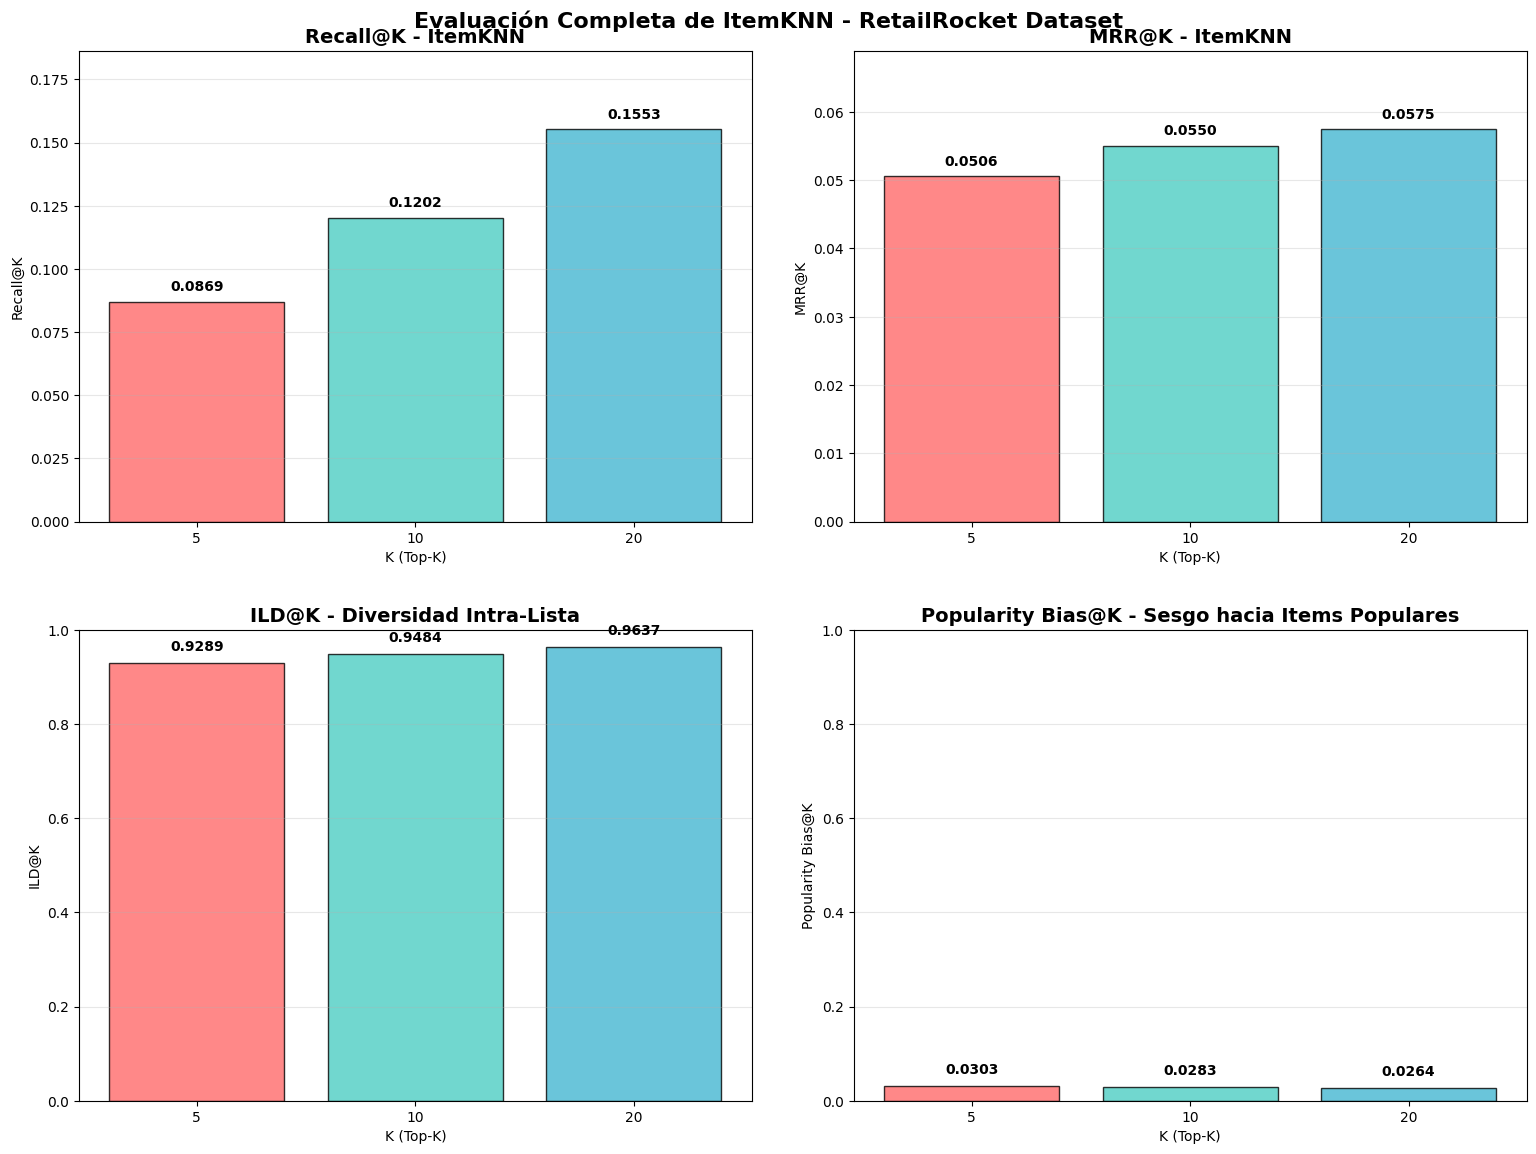


📋 TABLA DE RESUMEN - ITEMKNN RETAILROCKET
Métrica              K=5          K=10         K=20        
------------------------------------------------------------
Recall               0.0869       0.1202       0.1553      
MRR                  0.0506       0.0550       0.0575      
ILD                  0.9289       0.9484       0.9637      
Popularity Bias      0.0303       0.0283       0.0264      

📈 ANÁLISIS DE TENDENCIAS - ITEMKNN:
   🎯 Recall: Mejora al aumentar K
   📊 MRR: Mejora al aumentar K
   🌈 ILD: Mejora al aumentar K
   ⭐ Pop. Bias: Disminuye al aumentar K


In [10]:
# VISUALIZACIÓN COMPLETA
def create_comprehensive_visualization_itemknn(results):
    """Crea visualizaciones completas de las métricas de ItemKNN"""

    # Configurar estilo
    plt.style.use('default')
    sns.set_palette("husl")

    # Crear figura con subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    k_values = [5, 10, 20]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # 1. Recall@K
    recall_values = [results[f'recall_{k}'] for k in k_values]
    bars1 = ax1.bar([str(k) for k in k_values], recall_values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Recall@K - ItemKNN', fontsize=14, fontweight='bold')
    ax1.set_xlabel('K (Top-K)')
    ax1.set_ylabel('Recall@K')
    ax1.set_ylim(0, max(recall_values) * 1.2 if max(recall_values) > 0 else 0.1)
    ax1.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars1, recall_values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(recall_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 2. MRR@K
    mrr_values = [results[f'mrr_{k}'] for k in k_values]
    bars2 = ax2.bar([str(k) for k in k_values], mrr_values, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('MRR@K - ItemKNN', fontsize=14, fontweight='bold')
    ax2.set_xlabel('K (Top-K)')
    ax2.set_ylabel('MRR@K')
    ax2.set_ylim(0, max(mrr_values) * 1.2 if max(mrr_values) > 0 else 0.1)
    ax2.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars2, mrr_values)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mrr_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 3. ILD@K (Diversidad)
    ild_values = [results[f'ild_{k}'] for k in k_values]
    bars3 = ax3.bar([str(k) for k in k_values], ild_values, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_title('ILD@K - Diversidad Intra-Lista', fontsize=14, fontweight='bold')
    ax3.set_xlabel('K (Top-K)')
    ax3.set_ylabel('ILD@K')
    ax3.set_ylim(0, 1.0)  # ILD está entre 0 y 1
    ax3.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars3, ild_values)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 4. Popularity Bias@K
    pop_bias_values = [results[f'popularity_bias_{k}'] for k in k_values]
    bars4 = ax4.bar([str(k) for k in k_values], pop_bias_values, color=colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Popularity Bias@K - Sesgo hacia Items Populares', fontsize=14, fontweight='bold')
    ax4.set_xlabel('K (Top-K)')
    ax4.set_ylabel('Popularity Bias@K')
    ax4.set_ylim(0, 1.0)  # Bias está entre 0 y 1
    ax4.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars4, pop_bias_values)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # Ajustar layout
    plt.tight_layout(pad=3.0)

    # Agregar título general
    fig.suptitle('Evaluación Completa de ItemKNN - RetailRocket Dataset',
                fontsize=16, fontweight='bold', y=0.98)

    plt.show()

# Crear visualizaciones de ItemKNN
create_comprehensive_visualization_itemknn(results)

# Crear tabla de resumen
print("\n📋 TABLA DE RESUMEN - ITEMKNN RETAILROCKET")
print("="*60)
print(f"{'Métrica':<20} {'K=5':<12} {'K=10':<12} {'K=20':<12}")
print("-" * 60)
print(f"{'Recall':<20} {results['recall_5']:<12.4f} {results['recall_10']:<12.4f} {results['recall_20']:<12.4f}")
print(f"{'MRR':<20} {results['mrr_5']:<12.4f} {results['mrr_10']:<12.4f} {results['mrr_20']:<12.4f}")
print(f"{'ILD':<20} {results['ild_5']:<12.4f} {results['ild_10']:<12.4f} {results['ild_20']:<12.4f}")
print(f"{'Popularity Bias':<20} {results['popularity_bias_5']:<12.4f} {results['popularity_bias_10']:<12.4f} {results['popularity_bias_20']:<12.4f}")
print("="*60)

# Análisis de tendencias
print(f"\n📈 ANÁLISIS DE TENDENCIAS - ITEMKNN:")
print(f"   🎯 Recall: {'Mejora' if results['recall_20'] > results['recall_5'] else 'Se mantiene'} al aumentar K")
print(f"   📊 MRR: {'Mejora' if results['mrr_20'] > results['mrr_5'] else 'Disminuye'} al aumentar K")
print(f"   🌈 ILD: {'Mejora' if results['ild_20'] > results['ild_5'] else 'Disminuye'} al aumentar K")
print(f"   ⭐ Pop. Bias: {'Aumenta' if results['popularity_bias_20'] > results['popularity_bias_5'] else 'Disminuye'} al aumentar K")
